***
           ***Text classification by severity using LLM**   
**Description:** Classifying the text based on severity into 3 categories only for the texts classified as negative by the BERT model. The 3 categories are: mild, moderate and severe.
The model used is:
* base_model = "mistralai/Mistral-7B-Instruct-v0.2"

* adapter = "gargvinayakk/dpo-mistralai-7b-mental-health" (DPO trained on the base model)

**Contributor:** N Priyanka

**Datasets used** : testing_data_for_sentiment_analysis.xlsx (This was prepared by me by taking random posts and generating the label and severity by prompting ChatGPT

***

In [ ]:
!pip install auto-gptq
!pip install optimum
!pip -qqq install bitsandbytes accelerate
!pip install peft

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftConfig, PeftModel

base_model = "mistralai/Mistral-7B-Instruct-v0.2"
adapter = "gargvinayakk/dpo-mistralai-7b-mental-health"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    add_bos_token=True,
    trust_remote_code=True,
    padding_side='left'
)

# Create peft model using base_model and finetuned adapter
config = PeftConfig.from_pretrained(adapter)
model = AutoModelForCausalLM.from_pretrained(base_model,
                                             load_in_4bit=True,
                                            device_map='auto',torch_dtype='auto')
model = PeftModel.from_pretrained(model, adapter)



device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): L

In [4]:
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/Mental_health_prediction/testing_data_for_sentiment_analysis.xlsx", sheet_name ="Sheet2")

In [5]:
df.shape

(16, 3)

In [6]:
prompt = "Classify the text into three categories: mild, moderate and severe based on the severity of the text. Do not provide any explanation. Provide only the category."

In [7]:
user_prompt = df['text'].tolist()

In [8]:
outputs = []
for text in user_prompt:
  text = f"{prompt} [INST] {text} [/INST]"
  inputs = tokenizer(text, return_tensors="pt")
  # Set padding token
  tokenizer.add_special_tokens({"pad_token": "[PAD]"})
  # generate output
  output = model.generate(input_ids=inputs["input_ids"].to("cuda"),max_length=512,temperature=0.1,pad_token_id=tokenizer.pad_token_id)
  outputs.append(output)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [9]:
# Convert each tensor to NumPy array
numpy_arrays = [tensor.cpu().numpy() for tensor in outputs]

In [10]:
numpy_arrays

[array([[    1,  4950,  1575,   272,  2245,   778,  1712, 13187, 28747,
         16583, 28725, 22651,   304, 13645,  2818,   356,   272,  2425,
           472,   302,   272,  2245, 28723,  2378,   459,  3084,   707,
         13268, 28723,  7133,   547,   865,   272,  8011, 28723,   733,
         16289, 28793,   315,   873,   315,   927,   298,  3215,   395,
           586, 14992, 28723,  1092,   315,   949, 28742, 28707,   873,
           910,   304,   315,   949, 28742, 28707,   947,   298,  1912,
          3637, 28723,  5660,   541,   315,  3215,   395, 14992,  1671,
          7124,  3637, 28804,   733, 28748, 16289, 28793,  3813,   263,
           380, 28723,   415,  2245, 12825,   396, 13619,   302, 14992,
           562,   264, 19238,   617,   298,  5695,  1316,   442,  4098,
           378,   395,  2663, 28723,   851, 12308,   264, 22651,  2184,
           302,  2425,   472, 28723,  2993, 28725,   378, 28742, 28713,
          2278,   298,  5039,   369, 11246,  5024,  1316,   541,

In [11]:
# Decode each NumPy array
decoded_outputs = []
for numpy_array in numpy_arrays:
    # Convert NumPy array back to list
    output_ids = numpy_array.tolist()[0]

    # Decode the token IDs
    decoded_output = tokenizer.decode(output_ids, skip_special_tokens=True)

    # Add decoded output to the list
    decoded_outputs.append(decoded_output)

In [12]:
decoded_outputs

["Classify the text into three categories: mild, moderate and severe based on the severity of the text. Do not provide any explanation. Provide only the category. [INST] I know I need to deal with my depression. But I don't know how and I don't want to tell anyone.How can I deal with depression without telling anyone? [/INST] Moderate. The text indicates an awareness of depression but a reluctance to seek help or share it with others. This suggests a moderate level of severity. However, it's important to note that seeking professional help can be a crucial step towards managing depression.",
 "Classify the text into three categories: mild, moderate and severe based on the severity of the text. Do not provide any explanation. Provide only the category. [INST] I feel like I'm constantly bombarded with images and messages on social media that make me feel inadequate and insecure. [/INST] Moderate. This text suggests a significant impact on feelings of inadequacy and insecurity, indicating

In [13]:
len(decoded_outputs)

16

In [14]:
# Extract categories
categories = []
for sample in decoded_outputs:
    category = sample.split("] ")[-1].strip() # Extract the last part after "] " and remove leading/trailing whitespace
    category = category.split(".")[0].strip()  # Extract the first part before the period and remove leading/trailing whitespace
    category = category.split("\n")[0].strip()
    categories.append(category)

In [28]:
categories

['Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Severe',
 'Moderate',
 'Severe',
 'Moderate',
 'Moderate']

# Plotting the confusion matrix and printing the classification report.

In [22]:
y_pred = categories

In [25]:
y_pred = [s.lower() for s in y_pred]

In [17]:
y_true = df['severity'].tolist()

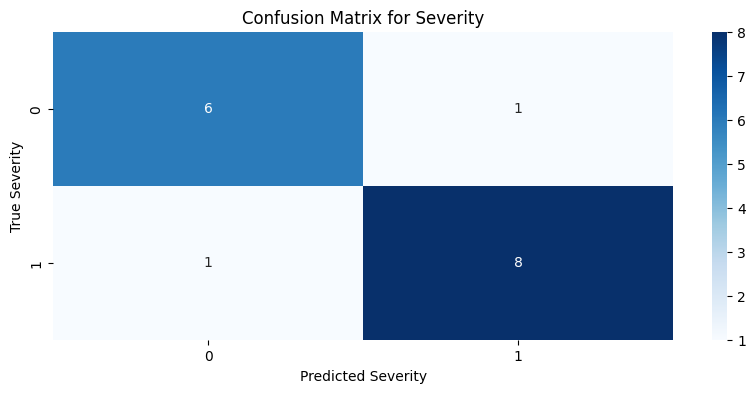

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix for severity
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Severity')
plt.ylabel('True Severity')
plt.title('Confusion Matrix for Severity')
plt.show()


In [27]:
class_report = classification_report(y_true, y_pred)
print(class_report)

              precision    recall  f1-score   support

    moderate       0.86      0.86      0.86         7
      severe       0.89      0.89      0.89         9

    accuracy                           0.88        16
   macro avg       0.87      0.87      0.87        16
weighted avg       0.88      0.88      0.88        16

